In [1]:
from neuron import h
from neuron.units import mV, ms
h.load_file("stdrun.hoc")
import matplotlib.pyplot as plt
import plotly
h.load_file("stdlib.hoc")
h.load_file("import3d.hoc")
h.load_file("stdrun.hoc")
import json

import sys
import numpy as np
import queue
sys.path.insert(1, "./")
import Stimuli

## morpho_n_inputs
Used to prototype n inputs experiment for morphologically detailed CA1 pyramidal neuron.

Code moved to n_inputs_morpho.py for scripting. 

## set up cell

In [2]:
class Event:
    def __init__(self, _id, t, tau, rev_potential, seg_ind, weight):
        self._id = _id
        self.t = t
        self.tau = tau
        self.rev_potential = rev_potential
        self.seg_ind = seg_ind
        self.weight = weight
    def __lt__(self, other):
        return self.t < other.t
    def __repr__(self):
        return str(self.source) + str(self.t)
    def deliver(self):
        #print(self)
        return
    
def get_n_events(event_log, n):
    # currently ignores output spike events
    events = event_log['stimuli'][-n:]

    return events

In [3]:
class Poisson_Times:
    def __init__(self, _id, tau, interval, weight, rev_potential, event_times=None,
                 max_time=1000000, delay=0, start=0, number=99999999):
        self._id = _id
        self.rev_potential = rev_potential
        self.max_time = max_time
        self.interval = interval
        self.weight = weight
        self.delay = delay
        self.tau = tau
        self.start = start
        self.number = number
        self.event_times = []
        
        if event_times:
            # load event times
            self.event_times = event_times
        else:
            # generate event times
            event_time = 0
            for i in range(number):
                event_time += np.random.exponential(self.interval)
                if event_time < max_time:
                    self.event_times.append(event_time)
                else:
                    break
                    
def poisson_times_from_stim_params(stim_params, max_time):
    poisson_times = {}
    for _id in stim_params:
        for seg_ind in stim_params[_id]['seg_inds']:
            poisson_times[seg_ind] = Poisson_Times(
                _id, 
                stim_params[_id]['tau'],
                stim_params[_id]['interval'],
                stim_params[_id]['weight'],
                stim_params[_id]['rev_potential'],
                max_time=max_time
            )
    return poisson_times

class Pyramidal:
    def __init__(self):
        self.load_morphology()
        # do discretization, ion channels, etc
        for sec in self.all:
            sec.nseg = int(1 + 2 * (sec.L // 40))
        h.hh.insert(self.axon)
        h.hh.insert(self.soma)
        h.pas.insert(self.dend)  # passive leak
        h.pas.insert(self.apic)  # passive leak
        self.all_input_segments = []
        for morph in [self.apic, self.dend]:
            for part in morph:
                # self.all_input_segments.append(part)
                self.all_input_segments.extend([seg for seg in part.allseg()])
        # storing input mechanisms
        self.syns = []
        self.net_stims = []
        self.netcons = []
        self.stims = []
        # recording
        # need to store all state variables here
        self.v_apic = h.Vector().record(self.apic[100](0.5)._ref_v)
        self.v_soma = h.Vector().record(self.soma[0](0.5)._ref_v)
        self.v_axon = h.Vector().record(self.axon[0](0.5)._ref_v)
        self._t = h.Vector().record(h._ref_t)
        
        # spike detector
        self.spike_detector = h.NetCon(self.axon[0](0.5)._ref_v, None, sec=self.axon[0])
        self.spike_times = h.Vector()
        self.spike_detector.record(self.spike_times)

    def __repr__(self):
        return "pyr"

    def load_morphology(self):
        cell = h.Import3d_SWC_read()
        cell.input("./neuron_nmo/amaral/CNG version/c91662.CNG.swc")
        i3d = h.Import3d_GUI(cell, False)
        i3d.instantiate(self)
        
    def connect_input(self, stimuli, seg):
        '''
        :param stimuli: Poisson_Times class object
        :param seg: NEURON simulation segment
        :return:
        '''
        syn = h.ExpSyn(seg)
        syn.tau = stimuli.tau
        syn.e = stimuli.rev_potential

        vec_stim_times = h.Vector(stimuli.event_times)
        vec_stim = h.VecStim()
        vec_stim.play(vec_stim_times)

        nc = h.NetCon(vec_stim, syn)
        nc.weight[0] = 1  # stimuli.weight
        nc.delay = stimuli.delay

        self.syns.append(syn)
        self.netcons.append(nc)

        netstims = [h.NetStim() for stim_time in stimuli.event_times]
        for netstim, event_time in zip(netstims, stimuli.event_times):
            netstim.number = 1
            netstim.start = event_time
            netcon = h.NetCon(netstim, syn)
            netcon.weight[0] = stimuli.weight
            netcon.delay = 0 * ms

            self.netcons.append(netcon)
        self.stims.extend(netstims)

def event_sim(events):
    '''

    :param events:
    :param stim_params:
    :return:
    '''
    pyr = Pyramidal()

    # generate necessary synapses
    syns = {}
    for event in events:
        syns[event.seg_ind] = h.ExpSyn(pyr.all_input_segments[event.seg_ind])
        syns[event.seg_ind].tau = event.tau
        syns[event.seg_ind].e = event.rev_potential

    # create net connections for each stimulus
    min_event_time = min([event.t for event in events])
    max_event_time = max([event.t for event in events])

    netstims = [h.NetStim() for event in events]
    for netstim, event in zip(netstims, events):
        netstim.number = 1
        netstim.start = event.t - min_event_time
        netcon = h.NetCon(netstim, syns[event.seg_ind])
        netcon.weight[0] = event.weight
        netcon.delay = 0 * ms
        pyr.netcons.append(netcon)

    # run simulation
    h.finitialize(-65)
    h.continuerun(max_event_time - min_event_time + 20)
    nsts = [spike + min_event_time for spike in list(pyr.spike_times)]
    nsts = [spike for spike in nsts if spike > max_event_time]
    if len(nsts) > 0:
        return nsts[0]
    else:
        return None

In [4]:
def generate_event_queue(stimuli):
    '''
    :param stimuli: stimuli generated from poisson_times_from_stim_params
    :param max_time:
    :return:
    '''
    pq = queue.PriorityQueue()
    for seg_ind in stimuli:
        for t in stimuli[seg_ind].event_times:
            pq.put(Event(
                'stim', t, stimuli[seg_ind].tau, stimuli[seg_ind].rev_potential, seg_ind, stimuli[seg_ind].weight)
                  )
    return pq

def event_type2color(event_type):
    if event_type == 'e':
        return 'red'
    elif event_type == 'i':
        return 'blue'
    elif event_type == 'o':
        return 'green'
    else:
        return 'magenta'

## simulate comparison cell

In [5]:
pyr = Pyramidal()

stim_params = {
        'e': {
            'n_stim_sets': 10,
            'tau': 2,
            'interval': 25,
            'weight': .25,
            'rev_potential': 0,
            'seg_inds': np.random.randint(0, len(pyr.all_input_segments), 10)
        },
        'i': {
            'n_stim_sets': 5,
            'tau': 6,
            'interval': 25,
            'weight': .25,
            'rev_potential': -80,
            'seg_inds': np.random.randint(0, len(pyr.all_input_segments), 5)
        }
    }

In [6]:
max_time = 1000
stimuli = poisson_times_from_stim_params(stim_params, max_time=max_time)

In [7]:
# write stimuli to file
stimuli_2_file = {
    int(seg_ind):
    {
        'stim_type': stimuli[seg_ind]._id,
        'rev_potential': stimuli[seg_ind].rev_potential,
        'interval': stimuli[seg_ind].interval,
        'weight': stimuli[seg_ind].weight,
        'tau': stimuli[seg_ind].tau,
        'event_times': stimuli[seg_ind].event_times
    } for seg_ind in stimuli
}
with open("test.json", "w") as fout:
    json.dump(stimuli_2_file, fout)

In [8]:
for seg in stimuli:
    pyr.connect_input(stimuli[seg], pyr.all_input_segments[seg])

In [9]:
h.finitialize(-65)
h.continuerun(max_time)

0.0

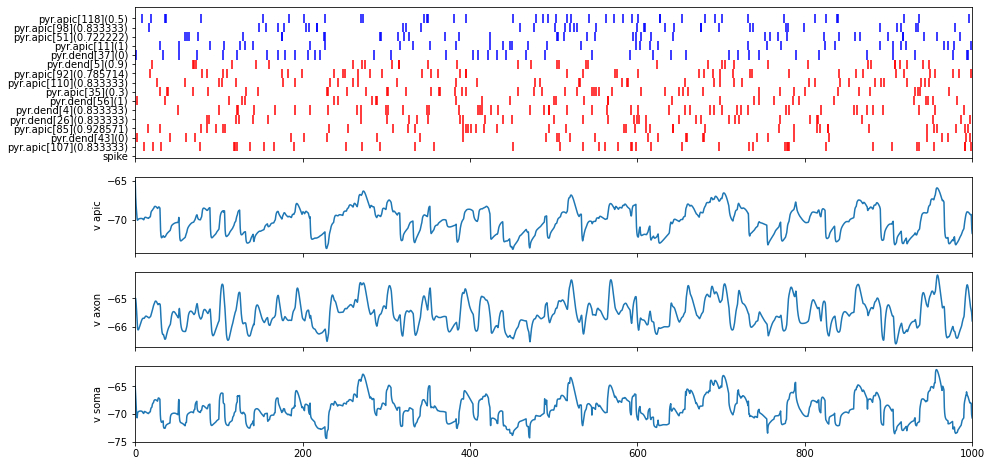

In [10]:
# view stimuli
fig, axes = plt.subplots(4, 1, figsize = (15, 8), sharex=True, gridspec_kw={'height_ratios': [2,1,1,1]})

# inputs
yticks = []
yticklabels = []
for i, seg in enumerate(stimuli):
    axes[0].vlines(stimuli[seg].event_times, i, i+1, color=event_type2color(stimuli[seg]._id))
    yticks.append(i+.5)
    yticklabels.append(str(pyr.all_input_segments[seg]))
    
axes[0].vlines(list(pyr.spike_times), -1, 0, 'green')
yticks.append(-.5)
yticklabels.append('spike')
axes[0].set_yticks(yticks)
axes[0].set_yticklabels(yticklabels)
    
axes[1].plot(pyr._t, pyr.v_apic)
axes[1].set_ylabel('v apic')

axes[2].plot(pyr._t, pyr.v_axon)
axes[2].set_ylabel('v axon')

axes[3].plot(pyr._t, pyr.v_soma)
axes[3].set_ylabel('v soma')

axes[-1].set_xlim(0, max_time)
plt.show()

In [11]:
# store spike_times here so that they are not written over by subsequent NEURON runs
obvs_spike_times = list(pyr.spike_times)

## find spiking histories

## n inputs experiment

In [12]:
stim_queue = generate_event_queue(stimuli)
n = 5

event_log = {
    'stimuli': [], # stores stimuli Event class objects
    'output_spikes': [] # stores stimuli Event class objects
}


while True:
    try:
        event = stim_queue.get_nowait()
        stim_queue.task_done()
        
        # add stimulus to log
        event_log['stimuli'].append(event)
        # generate new behavior
        events = get_n_events(event_log, n)        
        
        nst = event_sim(events)
        
        print('queue size:', stim_queue.qsize())
        if nst:            
            print('nsts:', nst)
            event_log['output_spikes'].append(nst)

    except queue.Empty:
        break

queue size: 597
queue size: 596
queue size: 595
queue size: 594
queue size: 593
queue size: 592
queue size: 591
queue size: 590
queue size: 589
queue size: 588
queue size: 587
queue size: 586
queue size: 585
queue size: 584
queue size: 583
queue size: 582
queue size: 581
queue size: 580
queue size: 579
queue size: 578
queue size: 577
queue size: 576
queue size: 575
queue size: 574
queue size: 573
queue size: 572
queue size: 571
queue size: 570
queue size: 569
queue size: 568
queue size: 567
queue size: 566
queue size: 565
queue size: 564
queue size: 563
queue size: 562
queue size: 561
queue size: 560
queue size: 559
queue size: 558
queue size: 557
queue size: 556
queue size: 555
queue size: 554
queue size: 553
queue size: 552
queue size: 551
queue size: 550
queue size: 549
queue size: 548
queue size: 547
queue size: 546
queue size: 545
queue size: 544
queue size: 543
queue size: 542
queue size: 541
queue size: 540
queue size: 539
queue size: 538
queue size: 537
queue size: 536
queue si

KeyboardInterrupt: 

In [ ]:
def remove_duplicate_spikes(spikes):
    final_spikes = []
    for spike_ind in range(len(spikes) - 1):
        if (spikes[spike_ind+1] - spikes[spike_ind]) > 1:
            final_spikes.append(spikes[spike_ind])
    final_spikes.append(spikes[-1])
    return final_spikes

In [ ]:
n_inputs_spikes = remove_duplicate_spikes(event_log['output_spikes'])

In [ ]:
plt.vlines(n_inputs_spikes, -.9, -.1, 'green')
plt.vlines(obvs_spike_times, .1, .9, 'green')

In [ ]:
exp_name = 'test'
outdir = '../morpho_nInputs_out/'
with open(f'{outdir}{exp_name}_rep_spikes.csv', 'w') as fout:
    for spike in n_inputs_spikes:
        fout.write(str(spike)+'\n')
with open(f'{outdir}{exp_name}_obv_spikes.csv', 'w') as fout:
    for spike in obvs_spike_times:
        fout.write(str(spike)+'\n')